In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
ROOT_DIR = "."

In [ ]:
flights = pd.concat([pd.read_csv(os.path.join(ROOT_DIR, file)) for file in os.listdir(ROOT_DIR) if file.endswith('.csv')])

flights

,ItinID,MktID,Year,Quarter,Origin,Dest,Miles,NumTicketsOrdered,AirlineCompany,PricePerTicket
0,202241227487,20224122748701,2022,4,TPA,PHX,1788.0,18.0,AA,248.50
1,202241227487,20224122748702,2022,4,PHX,TPA,1788.0,18.0,AA,248.50
2,202241227488,20224122748801,2022,4,TPA,PHX,1788.0,1.0,AA,249.00
3,202241227488,20224122748802,2022,4,PHX,TPA,1788.0,1.0,AA,249.00
4,202241227489,20224122748901,2022,4,TPA,PHX,1788.0,1.0,AA,250.00
...,...,...,...,...,...,...,...,...,...,...
23477640,202341141156,20234114115602,2023,4,DFW,SDF,733.0,2.0,AA,670.50
23477641,202341141157,20234114115701,2023,4,SDF,DFW,733.0,1.0,AA,741.00
23477642,202341141158,20234114115801,2023,4,SDF,DFW,733.0,1.0,AA,894.00
23477643,202341141158,20234114115802,2023,4,DFW,SDF,733.0,1.0,AA,894.00


In [ ]:
flights.dtypes

ItinID                 int64
MktID                  int64
Year                   int64
Quarter                int64
Origin                object
Dest                  object
Miles                float64
NumTicketsOrdered    float64
AirlineCompany        object
PricePerTicket       float64
dtype: object

In [ ]:
flights.isnull().sum()

ItinID               0
MktID                0
Year                 0
Quarter              0
Origin               0
Dest                 0
Miles                0
NumTicketsOrdered    0
AirlineCompany       0
PricePerTicket       0
dtype: int64

In [ ]:
# Check group sizes
print("ItinID group sizes:\n", flights.groupby('ItinID').size().describe())
print("MktID group sizes:\n", flights.groupby('MktID').size().describe())

ItinID group sizes:
 count    1.500169e+07
mean     1.565000e+00
std      5.097807e-01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      8.000000e+00
dtype: float64
MktID group sizes:
 count    23477645.0
mean            1.0
std             0.0
min             1.0
25%             1.0
50%             1.0
75%             1.0
max             1.0
dtype: float64


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

In [ ]:
#Create lag feature for price based on itinID
flights['price_itinID_lag1'] = flights.groupby('ItinID')['PricePerTicket'].shift(1)

In [ ]:
# Check the number of NaNs
nan_count = flights['price_itinID_lag1'].isna().sum()
print("Number of NaNs in price_itinID_lag1:", nan_count)

Number of NaNs in price_itinID_lag1: 15001691


In [ ]:
# Drop rows with NaN values
flights_cleaned = flights.dropna(subset=['price_itinID_lag1'])

In [ ]:
# Check if data is not empty
if flights_cleaned.empty:
    raise ValueError("The dataset is empty after dropping NaNs")

In [ ]:
# Confirm no NaNs remain in the lag feature
nan_count_after_dropping = flights_cleaned['price_itinID_lag1'].isna().sum()
print("Number of NaNs in price_itinID_lag1 after dropping rows:", nan_count_after_dropping)

Number of NaNs in price_itinID_lag1 after dropping rows: 0


In [ ]:
flights_cleaned

,ItinID,MktID,Year,Quarter,Origin,Dest,Miles,NumTicketsOrdered,AirlineCompany,PricePerTicket,price_itinID_lag1
1,202241227487,20224122748702,2022,4,PHX,TPA,1788.0,18.0,AA,248.5,248.5
3,202241227488,20224122748802,2022,4,PHX,TPA,1788.0,1.0,AA,249.0,249.0
5,202241227489,20224122748902,2022,4,PHX,TPA,1788.0,1.0,AA,250.0,250.0
7,202241227490,20224122749002,2022,4,PHX,TPA,1788.0,2.0,AA,250.5,250.5
9,202241227491,20224122749102,2022,4,PHX,TPA,1788.0,3.0,AA,252.0,252.0
...,...,...,...,...,...,...,...,...,...,...,...
23477633,202341141152,20234114115202,2023,4,DFW,SDF,733.0,1.0,AA,478.0,478.0
23477635,202341141153,20234114115302,2023,4,DFW,SDF,733.0,1.0,AA,494.5,494.5
23477637,202341141154,20234114115402,2023,4,DFW,SDF,733.0,1.0,AA,534.5,534.5
23477640,202341141156,20234114115602,2023,4,DFW,SDF,733.0,2.0,AA,670.5,670.5


In [ ]:
# Split features and target
X = flights_cleaned.drop(['PricePerTicket', 'ItinID', 'MktID'], axis=1)
y = flights_cleaned['PricePerTicket']

In [ ]:
# Identify categorical and numerical features
categorical_features = ['Origin', 'Dest', 'AirlineCompany', 'Quarter']
numerical_features = ['Year', 'Miles', 'NumTicketsOrdered', 'price_itinID_lag1']

In [ ]:
# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [ ]:
# Preprocessing for numerical data
numerical_transformer = StandardScaler()

In [ ]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Create and train the model within a pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror'))
])

In [ ]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Miles',
                                                   'NumTicketsOrdered',
                                                   'price_itinID_lag1']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Origin', 'Dest',
                                                   'AirlineCompany',
                                                   'Quarter'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
X_train.columns

Index(['Year', 'Quarter', 'Origin', 'Dest', 'Miles', 'NumTicketsOrdered',
       'AirlineCompany', 'price_itinID_lag1'],
      dtype='object')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 3.795904656148085


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error

In [ ]:
# Define a custom scoring function using mean absolute error
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [ ]:
# Define the k-fold cross-validation
kf = KFold(n_splits=8, shuffle=True, random_state=42)

In [ ]:
# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)

In [ ]:
mean_cv_mae = -np.mean(cv_scores)
std_cv_mae = np.std(cv_scores)

In [ ]:
print(f'mean cross-val mae {mean_cv_mae}')
print(f'standard deviation of cross-val mae {std_cv_mae}')

mean cross-val mae 3.794389617685062
standard deviation of cross-val mae 0.018056887910210945


In [ ]:
from sklearn.model_selection import cross_val_score

score=cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_error")

In [ ]:
rmse_scores = np.sqrt(-score)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
display_scores(rmse_scores)

Scores: [15.95324844 16.70127265 18.37724743 16.80087725 15.65796179]
Mean: 16.698121512371294
Standard deviation: 0.9451773000145715


In [ ]:
X_test.columns

Index(['Year', 'Quarter', 'Origin', 'Dest', 'Miles', 'NumTicketsOrdered',
       'AirlineCompany', 'price_itinID_lag1'],
      dtype='object')

In [ ]:
import joblib

joblib.dump(model, 'newModel.joblib')
joblib.dump(preprocessor, 'preprocessor.joblib')

['preprocessor.joblib']

In [ ]:
import pandas as pd

# Create the 'Date' column from 'Year' and 'Quarter'
def quarter_to_month(quarter):
    return {1: '01', 2: '04', 3: '07', 4: '10'}[quarter]

flights['Month'] = flights['Quarter'].apply(quarter_to_month)
flights['Day'] = '01'  # Use the first day of the month for simplicity
flights['Date'] = pd.to_datetime(flights['Year'].astype(str) + '-' + flights['Month'] + '-' + flights['Day'])

# Prepare the historical data
historical_data = flights[['Date', 'Origin', 'Dest', 'AirlineCompany', 'PricePerTicket']].copy()
historical_data.rename(columns={'PricePerTicket': 'Price'}, inplace=True)

# Save to CSV
historical_data.to_csv('historical_data.csv', index=False)


In [ ]:
X_train.iloc[0]

Year                   2022
Quarter                   2
Origin                  JFK
Dest                    MIA
Miles                1089.0
NumTicketsOrdered       1.0
AirlineCompany           AA
price_itinID_lag1     474.0
Name: 3867269, dtype: object

In [ ]:
flights.columns

Index(['ItinID', 'MktID', 'Year', 'Quarter', 'Origin', 'Dest', 'Miles',
       'NumTicketsOrdered', 'AirlineCompany', 'PricePerTicket',
       'price_itinID_lag1', 'Month', 'Day', 'Date'],
      dtype='object')

In [ ]:
#Check if there is some correlation between itinID on the same route in the same quarter and the price

true_false = flights.groupby(['Origin', 'Dest', 'Year', 'Quarter',
                              'ItinID'])['PricePerTicket'].apply(lambda x: x.is_monotonic_increasing).reset_index()

In [ ]:
true_false

,Origin,Dest,Year,Quarter,ItinID,PricePerTicket
0,ABE,BNA,2022,1,202212185163,True
1,ABE,BNA,2022,1,202212185164,True
2,ABE,BNA,2022,1,202212185165,True
3,ABE,BNA,2022,1,202212185182,True
4,ABE,BNA,2022,1,202212185183,True
...,...,...,...,...,...,...
23476027,YAK,SEA,2023,4,202341489158,True
23476028,YAK,SEA,2023,4,202341489159,True
23476029,YAK,TUS,2022,1,202211109464,True
23476030,YAK,TUS,2022,2,202221435074,True


In [ ]:
counts = true_false['PricePerTicket'].value_counts()

counts

PricePerTicket
True    23476032
Name: count, dtype: int64

In [ ]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_2619494/2450677784.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, kde=True)


<Axes: xlabel='NumTicketsOrdered', ylabel='Density'>

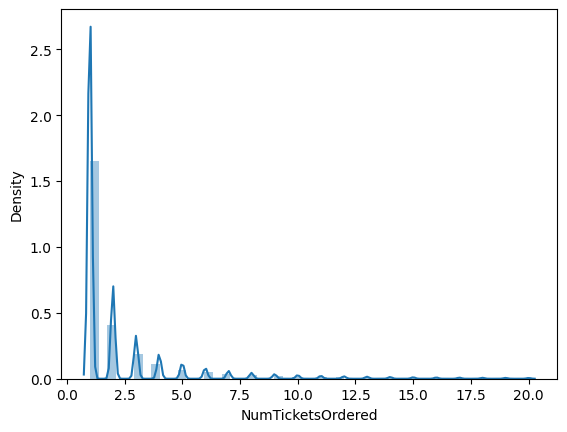

In [ ]:
import seaborn as sns
x = flights['NumTicketsOrdered']
sns.distplot(x)

In [ ]:
flights['AirlineCompany'].value_counts()

AirlineCompany
WN    6554810
UA    3678262
AA    3496903
DL    3396782
B6    1472799
AS    1159247
G4    1140688
NK    1118075
F9     841206
HA     292066
MX     120562
SY      98255
XP      83558
3M      24432
Name: count, dtype: int64

/tmp/ipykernel_2619494/3185994816.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y)


<Axes: xlabel='PricePerTicket', ylabel='Density'>

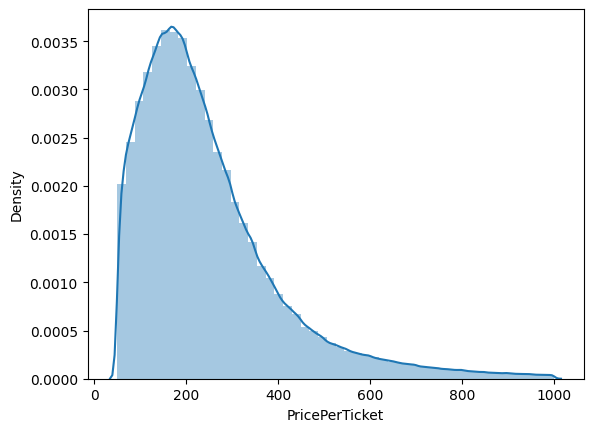

In [ ]:
import seaborn as sns
y = flights['PricePerTicket']
sns.distplot(y)

In [ ]:
flights['PricePerTicket'].describe()

count    2.347764e+07
mean     2.477419e+02
std      1.551027e+02
min      5.000000e+01
25%      1.404000e+02
50%      2.110000e+02
75%      3.100000e+02
max      1.000000e+03
Name: PricePerTicket, dtype: float64

/tmp/ipykernel_2619494/4212087649.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y2)


<Axes: xlabel='Miles', ylabel='Density'>

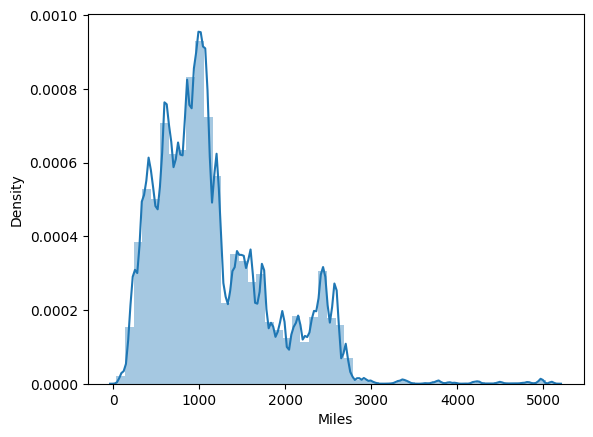

In [ ]:
import seaborn as sns
y2 = flights['Miles']
sns.distplot(y2)

In [ ]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


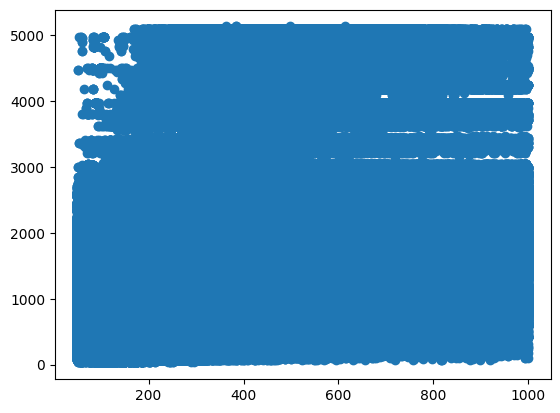

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(flights['PricePerTicket'], flights['Miles'])